<a href="https://colab.research.google.com/github/vchandraiitk/PokerCardGame/blob/master/Vikas_M3_NB_MiniProject_5_Customer_Segmentation_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
import os
os.chdir('/content/drive/MyDrive/ISC/MiniProject/M3_NB_MiniProject_5_Customer_Segmentation_Kmeans')

In [121]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

## Data Wrangling

In [122]:
#@title Download the data
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
#!unzip -qq Online_Retail.zip

## Load the data

In [123]:
# YOUR CODE HERE
df_retail = pd.read_csv("Online_Retail_Train.csv")
df_retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://thecleverprogrammer.com/2023/07/26/detect-and-remove-outliers-using-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [124]:
# YOUR CODE HERE
#There is a lot of redundant data. Identify such data and take appropriate action.
#Dropping Duplicate
intial = len(df_retail)
df_retail.drop_duplicates(inplace=True)
final = len(df_retail)
rows_dropped = intial - final
print(f'Intial Rows={intial} Final Rows= {final} Number of rows dropped: {rows_dropped}')

Intial Rows=514813 Final Rows= 510059 Number of rows dropped: 4754


In [125]:
#Removing rows with negative quantity
df_retail = df_retail.query('Quantity >= 0')

In [126]:
#Removing bank transaction.
df_retail = df_retail.query("StockCode  not in ('POST', 'PADS', 'M', 'DOT', 'C2')")

In [127]:
#Deleting rows where customer ID isn't present
df_retail.dropna(subset=["CustomerID"], inplace=True)

In [128]:
#Populating DayOfWeek column in dataframe
df_retail['DayOfWeek']=pd.to_datetime(df_retail.InvoiceDate).dt.day_name()

In [129]:
df_retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,Sunday


In [130]:
#Removing outliers with IQR
def remove_outliers_iqr(df):
    # Select only numerical columns
    num_df = df[['Quantity', 'UnitPrice']]
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
    Q1 = num_df.quantile(0.25)
    Q3 = num_df.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the DataFrame to remove outliers
    no_outliers_df = df[~((num_df < lower_bound) | (num_df > upper_bound)).any(axis=1)]
    return no_outliers_df
df_retail = remove_outliers_iqr(df_retail)

In [131]:
#Removing outliers with zscore
# from scipy import stats

# # Function to detect and remove outliers using Z-score method
# def remove_outliers_zscore(data, threshold=3):
#     z_scores = np.abs(stats.zscore(data))
#     filtered_data = data[(z_scores < threshold).all(axis=1)]
#     return filtered_data

# # Detect and remove outliers
# df_retail = remove_outliers_zscore(df_retail)

## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [132]:
# YOUR CODE HERE
#Are there any free items in the data? How many are there?
print(f"We have {df_retail.query('UnitPrice == 0').shape[0]} Free Items in data set")

We have 24 Free Items in data set


In [133]:
#number of transactions per country and visualize using an appropriate plot
df_retail.groupby('Country').size().sort_values(ascending=False)

,0
Country,
United Kingdom,285546
Germany,7051
France,6533
EIRE,5154
Spain,1937
Belgium,1585
Switzerland,1369
Portugal,1187
Norway,735


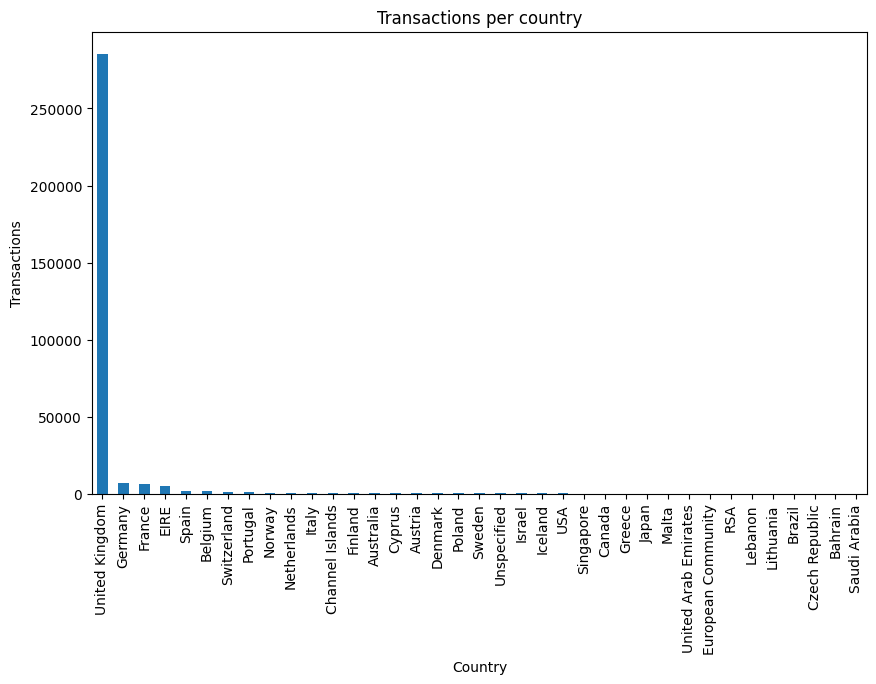

In [134]:
#number of transactions per country and visualize using an appropriate plot
plt.figure(figsize=(10,6))
df_retail.Country.value_counts().plot(kind='bar')
plt.title('Transactions per country')
plt.xlabel('Country')
plt.ylabel('Transactions')
plt.show()

In [135]:
#What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.
df_customer = df_retail.groupby('CustomerID').size().reset_index(name='Count')

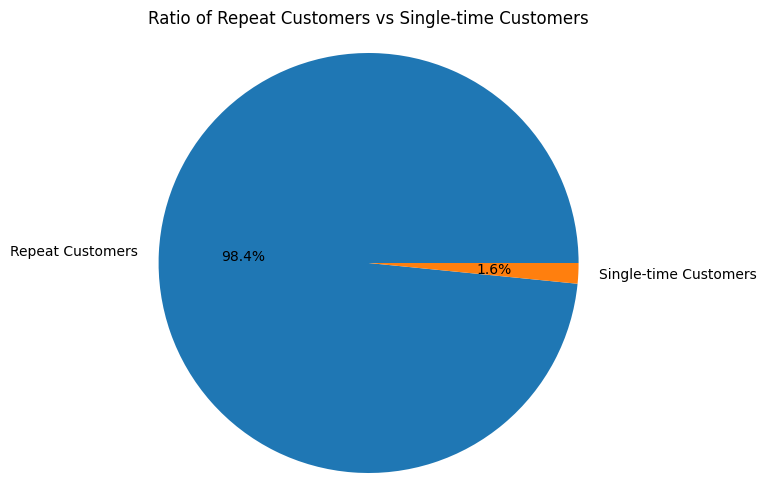

In [136]:
# Calculate the ratios
repeat_purchasers = df_customer[df_customer['Count'] > 1].shape[0]
single_time_purchasers = df_customer[df_customer['Count'] == 1].shape[0]
total_customers = repeat_purchasers + single_time_purchasers
repeat_ratio = repeat_purchasers / total_customers
single_time_ratio = single_time_purchasers / total_customers

# Create a DataFrame for visualization
ratios_df = pd.DataFrame({
    'Category': ['Repeat Customers', 'Single-time Customers'],
    'Ratio': [repeat_ratio, single_time_ratio]
})

# Plot the ratios
plt.figure(figsize=(8, 6))
plt.pie(ratios_df['Ratio'], labels=ratios_df['Category'], autopct='%1.1f%%')
plt.title('Ratio of Repeat Customers vs Single-time Customers')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

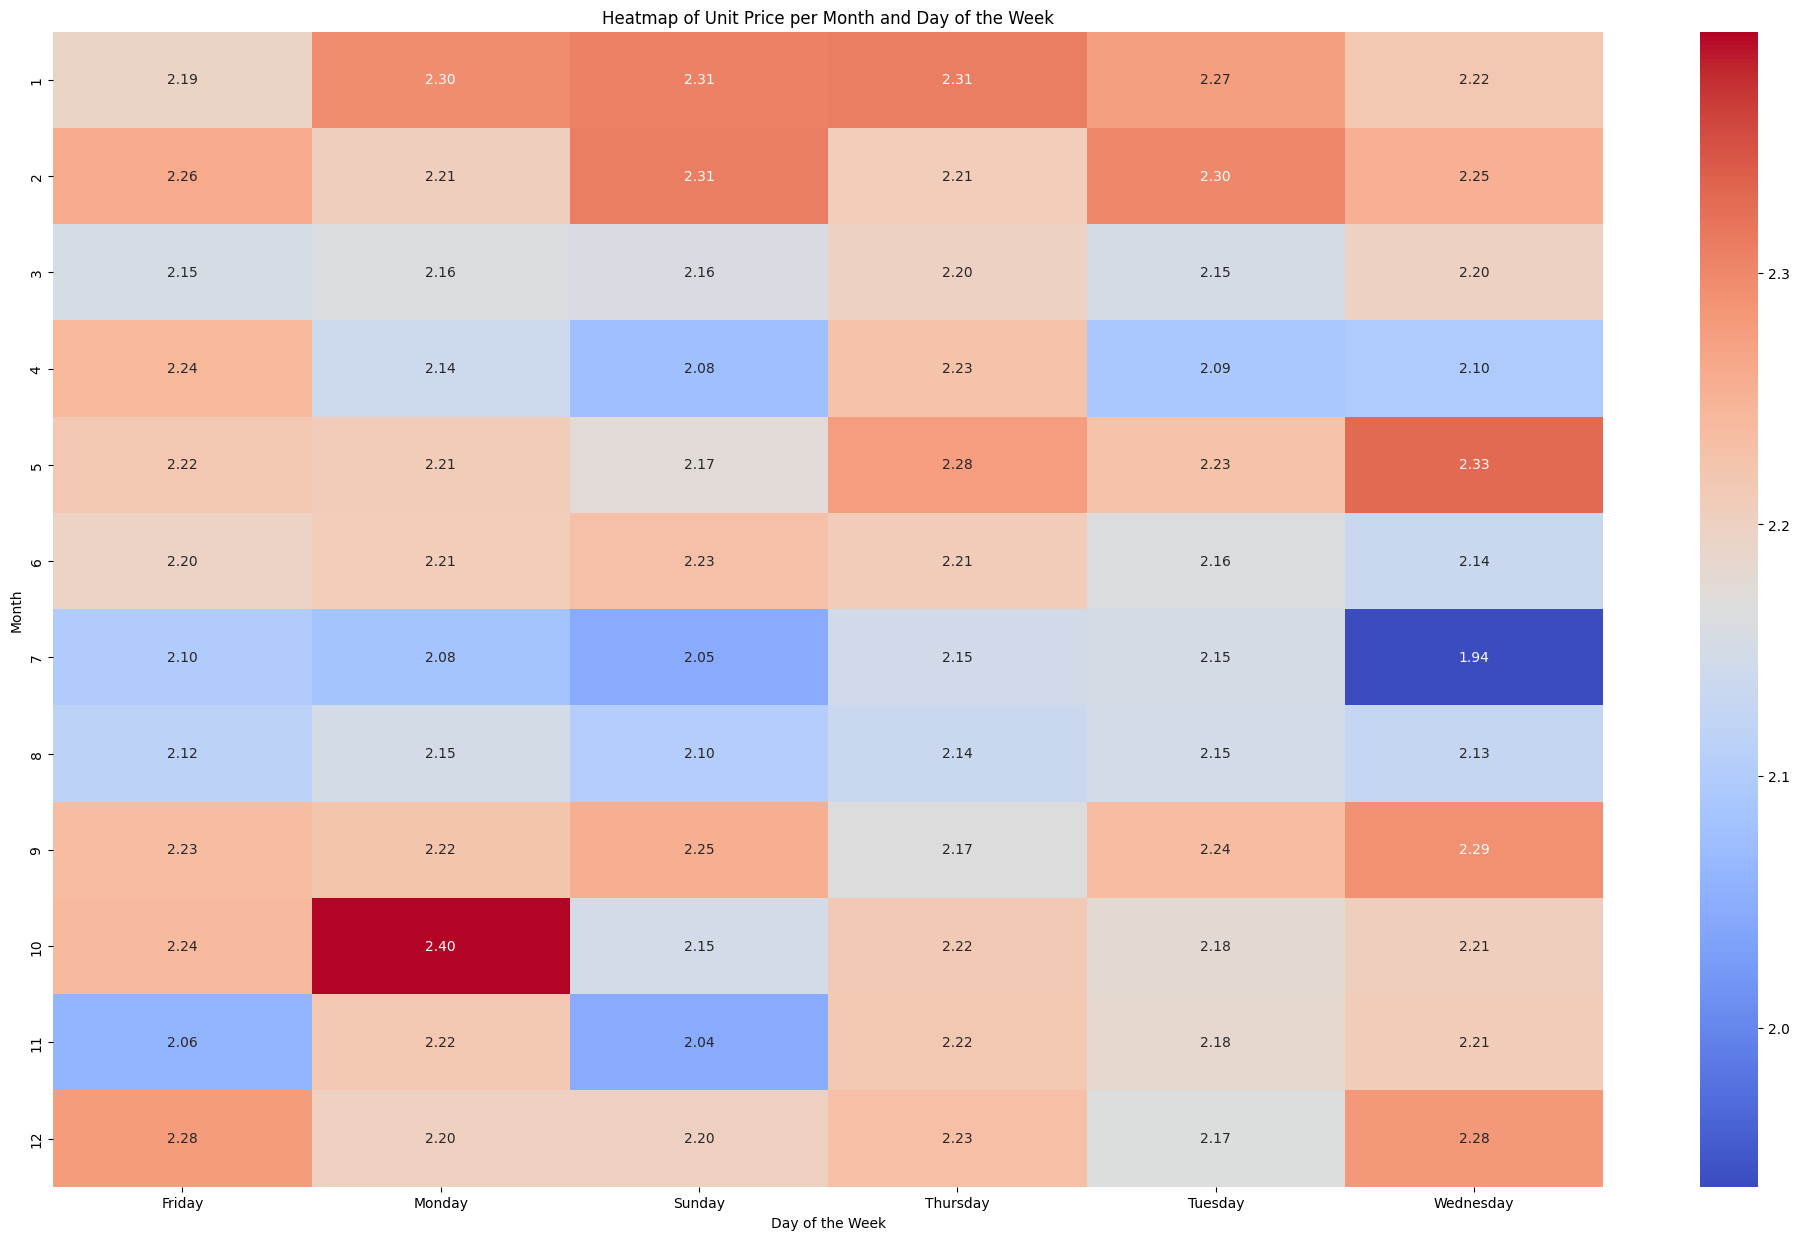

In [137]:
#Plot heatmap showing unit price per month and day of the week
# Extract month from InvoiceDate
df_retail['Month'] = pd.to_datetime(df_retail.InvoiceDate).dt.month

# Group by Month and DayOfWeek and calculate the mean UnitPrice
heatmap_data = df_retail.groupby(['Month', 'DayOfWeek'])['UnitPrice'].mean().unstack()

# Plotting the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap of Unit Price per Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.show()

In [138]:
#Find the top 10 customers who bought the most no.of items.
quantity_sum_by_customer = df_retail.groupby('CustomerID')['Quantity'].sum().reset_index()
top_10_customers = quantity_sum_by_customer.nlargest(10, 'Quantity')
print("Top 10 Customers by Quantity:")
print(top_10_customers)

Top 10 Customers by Quantity:
      CustomerID  Quantity
1825     14911.0     46783
542      13089.0     19477
3880     17841.0     18508
1389     14298.0     16611
323      12748.0     14297
1248     14096.0     12837
538      13081.0     11480
2002     15159.0      7683
2109     15311.0      7604
430      12921.0      7486


In [139]:
#Also find the top 10 Items bought by most no.of customers.
quantity_sum_by_items = df_retail.groupby('StockCode')['Quantity'].sum().reset_index()
top_10_items = quantity_sum_by_items.nlargest(10, 'Quantity')
print("Top 10 Items by Quantity:")
print(top_10_items)

Top 10 Items by Quantity:
     StockCode  Quantity
412      21212     14322
2855     84879     12841
3003    85099B     11587
3017    85123A     10220
165      20725      9408
1902     23203      8477
1039     22197      8415
1690     22961      8248
870      21977      8092
2916     84991      7959


## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [140]:
# YOUR CODE HERE
#Create a new column which represents Total amount spent by each customer
df_retail['TotalAmount'] = df_retail['Quantity'] * df_retail['UnitPrice']

In [160]:
#unique customer IDs by grouping and summing up all possible observations per customer
df_sum = df_retail.groupby('CustomerID')[['TotalAmount']].sum().reset_index()

### Scale the data

Apply `StandardScaler` on the features.

In [142]:
# YOUR CODE HERE for scaling
X = df_sum.drop('CustomerID', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 1.01503073e+00],
       [-4.24174040e-01],
       [ 6.03275494e-04],
       ...,
       [-4.19659665e-01],
       [ 4.40345528e-01],
       [-2.07717875e-02]])

## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

In [163]:
# YOUR CODE HERE to apply KMeans
# Select relevant features for clustering
features = df_retail[['TotalAmount']]

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

In [144]:
features['TotalAmount'].to_numpy()

array([10.08,  2.52, 15.6 , ...,  3.75, 35.4 , 17.85])

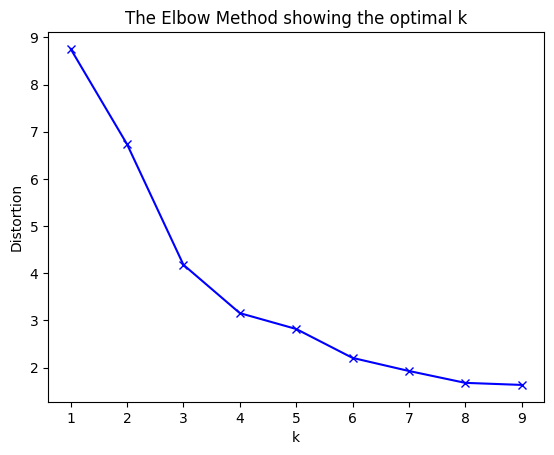

In [145]:
# YOUR CODE HERE
from scipy.spatial.distance import cdist
X = np.array(list(zip(features['TotalAmount'].to_numpy()))).reshape(len(features['TotalAmount'].to_numpy()), 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init=10).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [146]:
kmeans = KMeans(
    n_clusters=4,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=42
)

# Fit the K-means model
kmeans.fit(X)

# Extract and store the cluster centroids
centroids = kmeans.cluster_centers_

# Inverse transform the centroids to original scale
centroids_df = pd.DataFrame(scaler.inverse_transform(centroids), columns=['TotalAmount'])


In [170]:
centroids_df

,TotalAmount
0,36877.204267
1,11246.670963
2,165556.425605
3,75259.202122


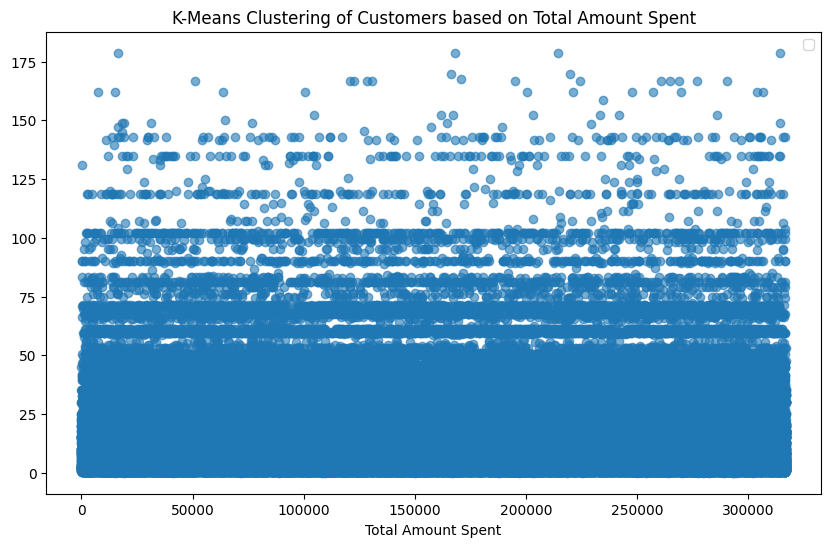

In [171]:
# Plot the centroids along with the data points
plt.figure(figsize=(10, 6))

# Scatter plot of the total amount spent by each customer
#plt.scatter(features['TotalAmount'], [0] * len(features), label='Customers', alpha=0.6)
plt.scatter(range(len(features)), features, alpha=0.6)


# Scatter plot of the cluster centroids
#plt.scatter(centroids_df['TotalAmount'], [0] * len(centroids_df), color='red', label='Centroids', marker='X', s=200)

plt.title('K-Means Clustering of Customers based on Total Amount Spent')
plt.xlabel('Total Amount Spent')
plt.legend()
plt.show()

### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [148]:
# YOUR CODE HERE


### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [149]:
# YOUR CODE HERE

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [150]:
# YOUR CODE HERE

### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [151]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555200,71459,HANGING JAM JAR T-LIGHT HOLDER,24,2011-06-01 12:05:00,0.85,17315.0,United Kingdom
1,554974,21128,GOLD FISHING GNOME,4,2011-05-27 17:14:00,6.95,14031.0,United Kingdom
2,550972,21086,SET/6 RED SPOTTY PAPER CUPS,4,2011-04-21 17:05:00,0.65,14031.0,United Kingdom


In [152]:
# YOUR CODE HERE

### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?